# Introduction

#SWDchallenge: visualize THIS data!
MARCH 01, 2019 BY COLE NUSSBAUMER KNAFLIC
UPDATE: It seems we may have overcomplicated things this time around. Let’s simplify!

You can download the file with country-to-country donations here. Create a visual to ANSWER ONE QUESTION: WHO DONATES? (Related subquestions you may also answer: How are donations distributed across countries?
* Who donates to whom? Are there any patterns, for example some group of countries tends to donate only to some specific group of other countries?)
*  How are donations distributed across countries?

* SHARE: Tweet your graph(s) or post publicly and email the link to SWDchallenge@storytellingwithdata.com.

NEW EXTENDED DEADLINE: Friday, March 15th (midnight PST). 

You’re of course welcome to do more (original full instructions follow), but our hopes are that simplifying will boost participation and we’ll get enough content to push some important data viz research forward!

# Background
Country to Country donation with data from AidData Core Research from 1947-2013

In [1]:
import pandas as pd
import qgrid
import altair as alt

from altair import X,Y,Color, Order, EncodingSortField
from pathlib import Path
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
DATA = Path('data')
df = pd.read_csv(DATA/'aiddata-countries-only.csv',index_col=0)

# Theme

In [3]:
def urban_theme():
    markColor = "#1696d2"
    axisColor = "#000000"
    backgroundColor = "#FFFFFF"
    font = "Lato"
    labelFont = "Lato"
    sourceFont = "Lato"
    gridColor = "#DEDDDD"
    main_palette = ["#1696d2", 
                    "#d2d2d2",
                    "#000000", 
                    "#fdbf11", 
                    "#ec008b", 
                    "#55b748", 
                    "#5c5859", 
                    "#db2b27", 
                   ]
    sequential_palette = ["#cfe8f3", 
                          "#a2d4ec", 
                          "#73bfe2", 
                          "#46abdb", 
                          "#1696d2", 
                          "#12719e", 
                         ]
    return {
        "width": 685,
        "height": 380,   
#        "autosize": "fit",
        "config": {
            "title": {
                "anchor": "start",
                "fontSize": 18,
                "font": font,
                "fontColor": "#000000"
            },
            "axisX": {
               "domain": True,
               "domainColor": axisColor,
               "domainWidth": 1,
               "grid": False,
               "labelFontSize": 12,
               "labelFont": labelFont,
               "labelAngle": 0,
               "tickColor": axisColor,
               "tickSize": 5,
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "title": "",
           },
           "axisY": {
               "domain": False,
               "grid": True,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 12,
               "labelFont": labelFont,
               "labelPadding": 8,
               "ticks": False,
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "titleAngle": 0,
               "titleY": -10,
               "titleX": 18,
           },
           "background": backgroundColor,
           "legend": {
               "labelFontSize": 12,
               "labelFont": labelFont,
               "symbolSize": 100,
               "symbolType": "square",
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "title": "",
               "orient": "top-left",
               "offset": 0,
           },
           "view": {
               "stroke": "transparent",
           },
           "range": {
               "category": main_palette,
               "diverging": sequential_palette,
           },
           "area": {
               "fill": markColor,
           },
           "line": {
               "color": markColor,
               "stroke": markColor,
               "strokewidth": 5,
           },
           "trail": {
               "color": markColor,
               "stroke": markColor,
               "strokeWidth": 0,
               "size": 1,
           },
           "path": {
               "stroke": markColor,
               "strokeWidth": 0.5,
           },
           "point": {
               "filled": True,
           },
           "text": {
               "font": sourceFont,
               "color": markColor,
               "fontSize": 11,
               "align": "right",
               "fontWeight": 400,
               "size": 11,
           }, 
           "bar": {
                "size": 40,
                "binSpacing": 1,
                "continuousBandSize": 30,
                "discreteBandSize": 30,
                "fill": markColor,
                "stroke": False,
            }, 
       },
    }
    
    
import altair as alt
alt.themes.register("my_custom_theme", urban_theme)
alt.themes.enable("my_custom_theme")

ThemeRegistry.enable('my_custom_theme')

# Without Cross Filtering

In [23]:
brush = alt.selection(type='interval', encodings=['y'])
sort=alt.EncodingSortField(
            field="commitment_amount_usd_constant",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )

In [24]:
df_donor = df[['donor','commitment_amount_usd_constant']].groupby(['donor']).sum().reset_index()


In [25]:
chart_donor_group = (alt.Chart(df_donor)# df_donor
 .mark_bar()
 .encode(y=Y('donor:N', sort=sort,title=''),
         x=X('sum(commitment_amount_usd_constant):Q', title='Amount'),
         tooltip=['sum(commitment_amount_usd_constant):Q'],
         color=alt.condition(brush, alt.value('#1696d2'), alt.value('lightgray'))
).transform_window(
    rank='rank(commitment_amount_usd_constant)',
    sort=[alt.SortField('commitment_amount_usd_constant', order='descending')]
).transform_filter(
    (alt.datum.rank <= 10)
).add_selection(brush)
              )

chart_donor_group.title = 'Top 10 Donors'


In [30]:
df_recipient = df[['donor','recipient','commitment_amount_usd_constant']].groupby(['donor','recipient']).sum().reset_index()
top20_recipient = df_recipient[['recipient','commitment_amount_usd_constant']].groupby('recipient').sum().nlargest(20,'commitment_amount_usd_constant').index.values
df_recipient_top20 = df_recipient[df_recipient['recipient'].isin(top20_recipient)]


In [31]:
chart_recipient = (alt.Chart(df_recipient) #df_recipient_top20
 .mark_bar()
 .encode(y=Y('recipient:N', sort=sort,title=''),
         x=X('sum(commitment_amount_usd_constant):Q', title='Amount')
))

chart_recipient.title='Top 20 Receipients in the world'


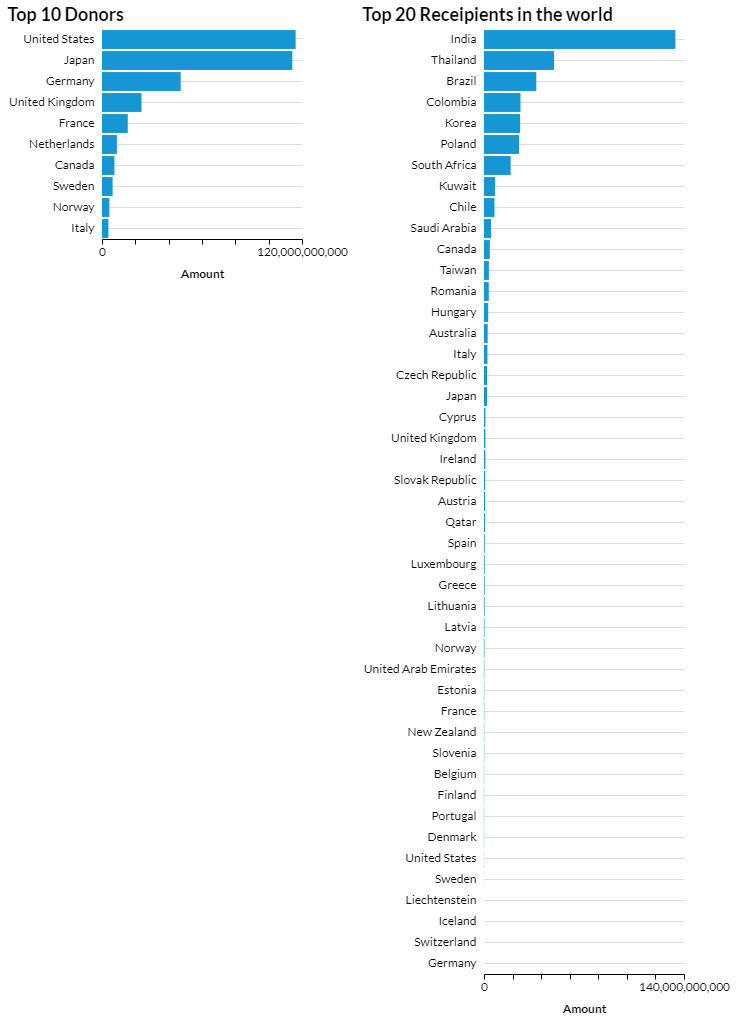

In [33]:
final_chart = chart_donor_group | chart_recipient
final_chart

# When added cross filter, the order cannot be keep

In [35]:
highlight = chart_recipient.encode(
    color=alt.value('goldenrod')
).transform_filter(brush)

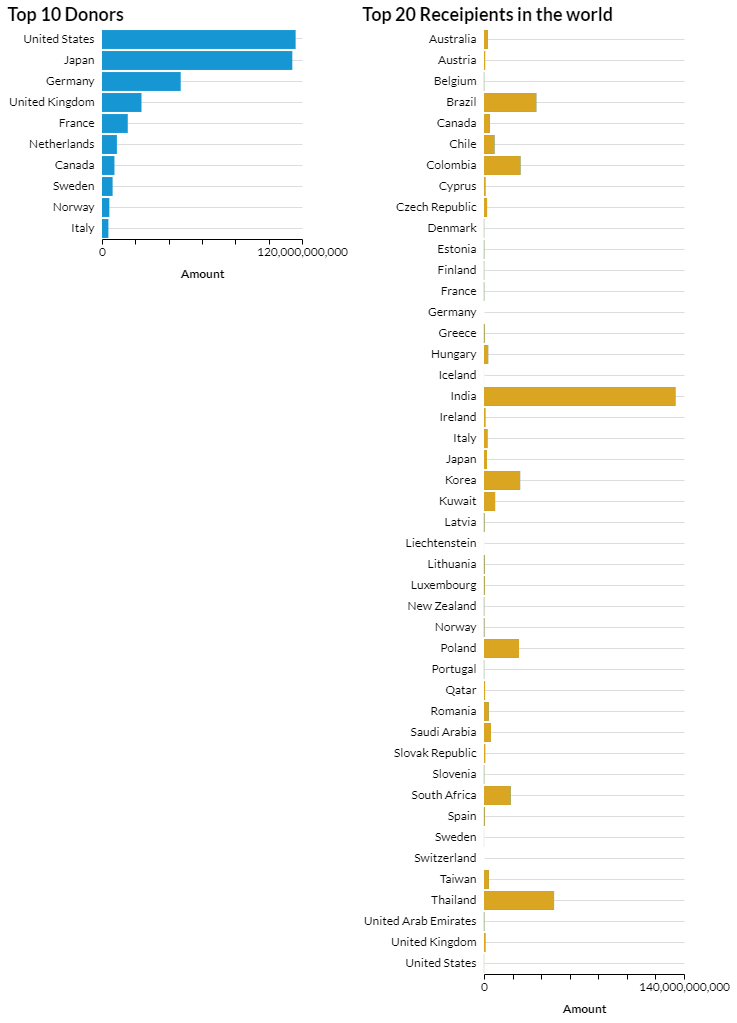

In [36]:
 chart_donor_group | (chart_recipient + highlight )